In [1]:
import os
os.environ["WANDB_API_KEY"] = "dcf9600e0485401cbb0ddbb0f7be1c70f96b32ef"
os.environ["WANDB_MODE"] = "disabled"
import argparse
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipdb
import wandb
from sigma_layer import SigmaLinear, SigmaConv, SigmaView
from utils import get_dataset, gradient_centralization, compute_SCL_loss
from utils_train import validate, save_best_model, test
import datetime

In [9]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# Training scheme group
method_parser = parser.add_argument_group("Method")
method_parser.add_argument('--method', type=str, default='SIGMA', choices=['SIGMA', 'BP', 'FA'])
method_parser.add_argument('--architecture', type=str, default='lenet', choices=['lenet', 'vgg'])
method_parser.add_argument('--actfunc', type=str, default='elu', choices=['tanh', 'elu', 'relu'])
method_parser.add_argument('--conv_dim', type=int, default=32, choices=[32, 64])
# Dataset group
dataset_parser = parser.add_argument_group('Dataset')
dataset_parser.add_argument('--dataset', type=str, default='CIFAR10', choices=['MNIST', 'CIFAR10'])
dataset_parser.add_argument('--batchsize', type=int, default=64)
dataset_parser.add_argument('--splitratio', type=float, default=0.2)
# Training group # LR, optimizer, weight_decay, momentum
training_parser = parser.add_argument_group('Training')
training_parser.add_argument('--epochs', type=int, default=100)
training_parser.add_argument('--lr', type=float, default=1)
training_parser.add_argument('--optimizer', type=str, default='SGD', choices=['RMSprop', 'Adam', 'SGD'])
# Seed group
seed_parser = parser.add_argument_group('Seed')
seed_parser.add_argument('--seed', type=int, default=2023)
args, _ = parser.parse_known_args()

# Set run_name
run_name = f"{args.dataset}_{args.method}_conv{args.conv_dim}-act{args.actfunc}_{args.optimizer}_{args.lr}_{args.seed}"
time_stamp = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")

# Set wandb
wandb.init(
    project="opt-sigma",
    name=run_name,
    # track hyperparameters and run metadata
    config={
    "algorithm": args.method,
    "architecture": "SimpleCNN",
    "dataset": args.dataset,
    "epochs": args.epochs,
    "lr": args.lr,
    "optimizer": args.optimizer,
    "seed": args.seed,
    "conv_dim": args.conv_dim,
    "actfunc": args.actfunc,
    }
)

print(f"Run name: {run_name}")

# Set seed
torch.manual_seed(args.seed), np.random.seed(args.seed)

# Set device
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

# Get dataset
train_loader, val_loader, test_loader = get_dataset(args)

class SigmaModel_SimpleCNN(nn.Module):
    def __init__(self, args):
        super(SigmaModel_SimpleCNN, self).__init__()
        if args.dataset == "CIFAR10":
            self.LN1 = torch.nn.LayerNorm((3,32,32), elementwise_affine=False) 
            self.conv1 = SigmaConv(args, 3, 32, 5, 3, 2)
            self.conv2 = SigmaConv(args, 32, 64, 3, 3, 2)
            self.view1 = SigmaView((64, 8, 8), 64 * 8 * 8)
            self.fc1 = SigmaLinear(args, 64 * 8 * 8, 128)
            self.fc2 = SigmaLinear(args, 128, 10)
            
        elif args.dataset == "MNIST":
            if args.architecture == "lenet":
                self.LN1 = torch.nn.LayerNorm((1,28,28), elementwise_affine=False) 
                self.conv1 = SigmaConv(args, 1, 32, 5, 2, 3)
                self.conv2 = SigmaConv(args, 32, 64, 5, 2, 3)
                self.view1 = SigmaView((64, 4, 4), 64 * 4 * 4)
                self.fc1 = SigmaLinear(args, 64 * 4 * 4, 512)
                self.fc2 = SigmaLinear(args, 512, 10)

        # orthoginal init self.fc1 and self.fc2
        init.orthogonal_(self.fc1.backward_layer.weight)
        init.sparse_(self.fc2.backward_layer.weight, sparsity=0.5)
                
        self.forward_params = list()
        self.backward_params = list()
        for layer in [self.conv1, self.conv2, self.fc1, self.fc2]:
            forward_params, backward_params = layer.get_parameters()
            self.forward_params += forward_params
            self.backward_params += backward_params

    def forward(self, x, detach_grad=False, return_activations=True):   
        a1 = self.conv1(x, detach_grad)
        a2 = self.conv2(a1, detach_grad)
        a2 = self.view1(a2, detach_grad)
        a3 = self.fc1(a2, detach_grad)
        a4 = self.fc2(a3, detach_grad)
        return [a1, a2, a3, a4]
        
    def reverse(self, target, detach_grad=True, return_activations=True):
        if target.shape == torch.Size([10]): 
            target = F.one_hot(target, num_classes=10).float().to(target.device)
        b3 = self.fc2.reverse(target, detach_grad)
        b2 = self.fc1.reverse(b3, detach_grad)
        b2 = self.view1.reverse(b2, detach_grad)
        b1 = self.conv2.reverse(b2, detach_grad)
        return [b1, b2, b3, target]


class SigmaLoss(nn.Module):
    def __init__(self, args):
        super(SigmaLoss, self).__init__()
        self.args = args
        self.final_criteria = nn.CrossEntropyLoss()
        self.local_criteria = compute_SCL_loss
        # self.local_criteria = compute_SCL_loss_square
        self.method = args.method

        self.max_pool = nn.MaxPool2d(2, 2)
        
    def forward(self, activations, signals, target, method="final"):
        if method == "local":
            loss = list()
            for idx, (act, sig) in enumerate(zip(activations[:-1], signals[:-1])):
                if len(sig.shape) == 4 and len(act.shape) == 2: 
                    act = act.reshape([len(act)] + list(sig.shape[1:]))
                if idx == 0 and torch.rand(1) > 0.5:
                    act = self.max_pool(act)
                    sig = self.max_pool(sig)
                # sig = sig[target]
                # loss += [F.mse_loss(act, sig)]
                # sig = sig[target]
                # sig = sig * (act > 0).float().detach()
                # sig = sig * act
                loss += [self.local_criteria(act, sig, target)]
            loss += [self.final_criteria(activations[-1], target)]
            return sum(loss), loss[-1].item()
        elif method == "final":
            loss = self.final_criteria(activations[-1], target)
            return loss, loss.item()
        
model = SigmaModel_SimpleCNN(args)
model.to(device)
if args.optimizer == "SGD": 
    forward_optimizer = optim.SGD(model.forward_params, lr=args.lr)
    backward_optimizer = optim.SGD(model.backward_params, lr=args.lr)

elif args.optimizer == "RMSprop": forward_optimizer = optim.RMSprop(model.forward_params, lr=args.lr, weight_decay=0)
elif args.optimizer == "Adam": forward_optimizer = optim.Adam(model.forward_params, lr=args.lr)
criteria = SigmaLoss(args)
    
target_10 = torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device)
# with torch.no_grad():
#     signals = model.reverse(target_10, return_activations=True)
    
best_val_loss = float('inf')

# for epoch in tqdm(range(args.epochs)):
best_model = copy.deepcopy(model)
for epoch in range(args.epochs):
    train_loss, train_counter = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        if args.method == "SIGMA":
            activations = model(data.to(device), detach_grad=True)
            signals = model.reverse(target_10, detach_grad=True)
            loss, loss_item = criteria(activations, signals, target.to(device), method="local")
        elif args.method == "BP":
            activations = model(data.to(device), detach_grad=False)
            loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        forward_optimizer.zero_grad(), backward_optimizer.zero_grad(), loss.backward()
        gradient_centralization(model)
        forward_optimizer.step(), backward_optimizer.step()
        train_loss += loss_item * len(data)
        train_counter += len(data)

    wandb.log({'train_loss': train_loss / train_counter}, step=epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        activations = model(data.to(device), detach_grad=True)
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        forward_optimizer.zero_grad(), loss.backward(), forward_optimizer.step()
    
    val_loss, val_acc = validate(model, val_loader, device, args, criteria, signals, epoch)

    wandb.log({'val_loss': val_loss, 'val_acc': val_acc,}, step=epoch)
    print(f"Ep {epoch} | tloss {train_loss / train_counter:.1f} | vloss {val_loss:.1f} | vacc {100 * val_acc:.2f}")
    best_val_loss, best_model = save_best_model(model, val_loss, best_val_loss, best_model, run_name, time_stamp)

test_loss, test_acc = test(best_model, test_loader, device, args, criteria, signals)

wandb.log({'test_loss': test_loss})
print(f'Test Accuracy: {100 * test_acc:.4f}%')

Run name: CIFAR10_SIGMA_conv32-actelu_SGD_1_2023
Files already downloaded and verified
Files already downloaded and verified
Ep 0 | tloss 2.0 | vloss 1.7 | vacc 41.03
Ep 1 | tloss 1.6 | vloss 1.5 | vacc 44.46
Ep 2 | tloss 1.5 | vloss 1.4 | vacc 48.95
Ep 3 | tloss 1.5 | vloss 1.4 | vacc 51.01
Ep 4 | tloss 1.4 | vloss 1.4 | vacc 51.76
Ep 5 | tloss 1.4 | vloss 1.3 | vacc 53.07
Ep 6 | tloss 1.4 | vloss 1.3 | vacc 54.38
Ep 7 | tloss 1.4 | vloss 1.3 | vacc 54.52
Ep 8 | tloss 1.3 | vloss 1.3 | vacc 55.62
Ep 9 | tloss 1.3 | vloss 1.3 | vacc 55.43
Ep 10 | tloss 1.3 | vloss 1.2 | vacc 56.73
Ep 11 | tloss 1.3 | vloss 1.2 | vacc 57.06
Ep 12 | tloss 1.3 | vloss 1.2 | vacc 57.54
Ep 13 | tloss 1.3 | vloss 1.2 | vacc 58.14
Ep 14 | tloss 1.3 | vloss 1.2 | vacc 58.23
Ep 15 | tloss 1.2 | vloss 1.2 | vacc 59.00
Ep 16 | tloss 1.2 | vloss 1.2 | vacc 58.73
Ep 17 | tloss 1.2 | vloss 1.2 | vacc 59.45
Ep 18 | tloss 1.2 | vloss 1.1 | vacc 60.16
Ep 19 | tloss 1.2 | vloss 1.2 | vacc 59.57
Ep 20 | tloss 1.2 | vloss

tensor([0.5922])

In [ ]:
.

In [ ]:
for act, sig in zip(activations, signals):
    print(act.shape, sig.shape)
    # print(f"act: {act.mean().item():.2f} sig: {sig.mean().item():.2f}")
    # break

torch.Size([64, 32, 16, 16]) torch.Size([64, 32, 16, 16])
torch.Size([64, 4096]) torch.Size([64, 64, 8, 8])
torch.Size([64, 128]) torch.Size([64, 128])
torch.Size([64, 10]) torch.Size([64, 10])


tensor([4, 8, 5, 2, 4, 8, 9, 1, 0, 8, 9, 0, 4, 1, 2, 8, 6, 2, 6, 2, 0, 6, 4, 0,
        5, 6, 9, 3, 1, 3, 6, 0, 1, 6, 4, 3, 1, 4, 8, 2, 9, 0, 7, 4, 4, 8, 5, 7,
        4, 9, 6, 8, 6, 1, 4, 8, 5, 4, 1, 6, 6, 6, 5, 9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


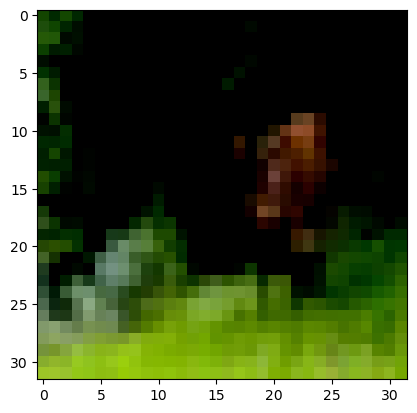

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4, 0, 6, 7, 7, 0, 4, 1, 4, 6, 6, 1, 1, 9, 1, 0, 2, 8, 2, 5, 9, 2, 9, 5,
        5, 0, 9, 3, 6, 6, 7, 5, 8, 6, 2, 0, 6, 8, 3, 9, 1, 3, 0, 8, 9, 8, 8, 2,
        1, 0, 9, 8, 3, 9, 0, 3, 2, 5, 7, 5, 3, 6, 0, 4])


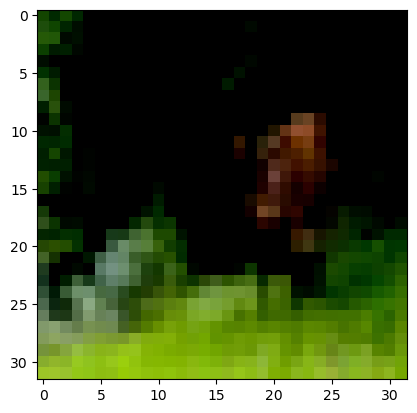

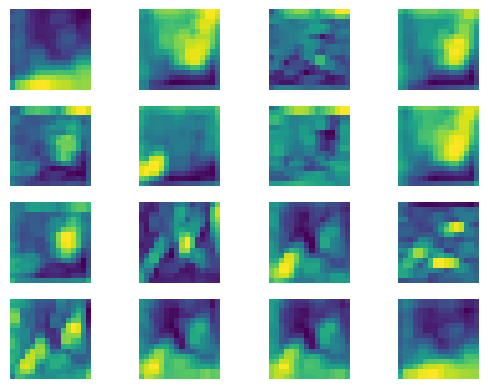

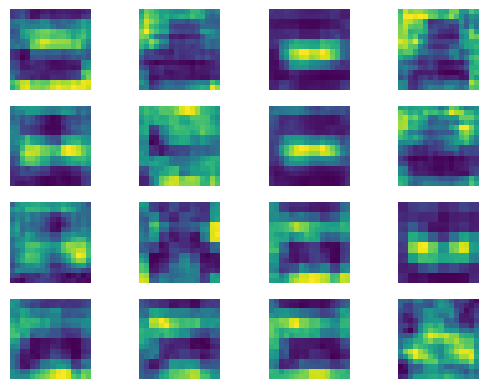

In [ ]:
print(target)
plt.imshow(data[0].permute(1,2,0).cpu().numpy())
plt.show()

fig, ax = plt.subplots(4, 4)
for i in range(16):
    ax[i//4, i%4].imshow(activations[0][0,i].detach().cpu().numpy())
    ax[i//4, i%4].axis('off')

fig, ax = plt.subplots(4, 4)
for i in range(16):
    ax[i//4, i%4].imshow(signals[0][0,i].detach().cpu().numpy())
    ax[i//4, i%4].axis('off')

In [ ]:
target


tensor([2, 8, 4, 8, 0, 8, 1, 5, 4, 8, 0, 2, 5, 0, 4, 9, 0, 5, 1, 7, 7, 7, 0, 8,
        1, 1, 5, 0, 6, 7, 6, 3, 8, 8, 3, 2, 9, 3, 0, 4, 8, 2, 2, 9, 9, 6, 5, 2,
        5, 3, 3, 8, 8, 3, 6, 6, 1, 8, 6, 7, 5, 6, 9, 2])